In [2]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
import random
seed = 7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
with h5py.File("train_catvnoncat.h5", "r") as f:
    X_all = np.array(f["train_set_x"])  # (209, 64, 64, 3)
    y_all = np.array(f["train_set_y"])  # (209,)

print("Original train-set shape:", X_all.shape, y_all.shape)

# Modified split parameters
last_digit = 7
new_train_count = 160 + last_digit  # 167
if new_train_count > X_all.shape[0]:
    raise ValueError("new_train_count > available images in original training set")

X_train_mod = X_all[:new_train_count]
y_train_mod = y_all[:new_train_count]

X_test_mod = X_all[new_train_count:]
y_test_mod = y_all[new_train_count:]

print("Modified train size:", X_train_mod.shape[0])
print("Modified test size:", X_test_mod.shape[0])


Original train-set shape: (209, 64, 64, 3) (209,)
Modified train size: 167
Modified test size: 42


In [6]:
class ArrayDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        # images: numpy array (N, H, W, C)
        # labels: numpy array (N,)
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]            # H,W,C numpy
        label = self.labels[idx].astype(np.float32)
        if self.transform:
            img = self.transform(img)     # returns tensor C,H,W
        return img, torch.tensor(label, dtype=torch.float32)


In [7]:
batch_size = 32

train_dataset_mod = ArrayDataset(X_train_mod, y_train_mod, transform=transform)
test_dataset_mod  = ArrayDataset(X_test_mod,  y_test_mod,  transform=transform)

train_loader_mod = DataLoader(train_dataset_mod, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader_mod  = DataLoader(test_dataset_mod,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Batches (train,test):", len(train_loader_mod), len(test_loader_mod))


Batches (train,test): 6 2


In [8]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)   # single logit output
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1e-6)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


In [9]:
num_epochs = 10  # same or increase as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader_mod:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)  # shape (N,1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_loader_mod.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {epoch_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10 — Train Loss: 0.7048
Epoch 2/10 — Train Loss: 0.5804
Epoch 3/10 — Train Loss: 0.4937
Epoch 4/10 — Train Loss: 0.3972
Epoch 5/10 — Train Loss: 0.3393
Epoch 6/10 — Train Loss: 0.3130
Epoch 7/10 — Train Loss: 0.2967
Epoch 8/10 — Train Loss: 0.3067
Epoch 9/10 — Train Loss: 0.3359
Epoch 10/10 — Train Loss: 0.3122


In [10]:
model.eval()
# helper to collect preds and labels
def collect_preds_labels(loader):
    preds = []
    labels_all = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy().ravel()
            batch_preds = (probs > 0.5).astype(int)
            preds.extend(batch_preds)
            labels_all.extend(labels.numpy().astype(int))
    return np.array(preds), np.array(labels_all)

train_preds_mod, train_labels_mod = collect_preds_labels(train_loader_mod)
test_preds_mod, test_labels_mod = collect_preds_labels(test_loader_mod)

train_acc = np.mean(train_preds_mod == train_labels_mod)
test_acc  = np.mean(test_preds_mod  == test_labels_mod)

print(f"Modified TRAIN accuracy (on {len(train_labels_mod)} images): {train_acc:.4f}")
print(f"Modified TEST accuracy  (on {len(test_labels_mod)} images): {test_acc:.4f}")


Modified TRAIN accuracy (on 167 images): 0.9760
Modified TEST accuracy  (on 42 images): 0.8571


In [11]:
mis_mask = (test_preds_mod != test_labels_mod)
mis_indices = np.where(mis_mask)[0]   # indices relative to the modified test set
print("Misclassified indices (0-based, relative to modified test set):")
print(mis_indices.tolist())
print("Total misclassified:", len(mis_indices))


Misclassified indices (0-based, relative to modified test set):
[0, 11, 13, 17, 18, 39]
Total misclassified: 6


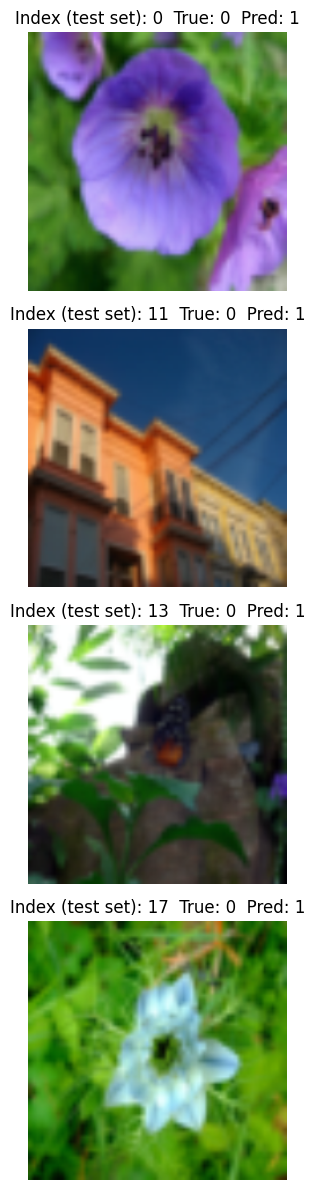

In [12]:
def unnormalize_tensor_to_np(tensor):
    # tensor is C x H x W
    img = tensor.cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225])[:, None, None] + np.array([0.485, 0.456, 0.406])[:, None, None]
    img = np.clip(img, 0, 1)
    img = np.moveaxis(img, 0, 2)  # H x W x C
    return img

num_show = min(4, len(mis_indices))
if num_show == 0:
    print("No misclassified examples to display.")
else:
    plt.figure(figsize=(12, 3 * num_show))
    for i in range(num_show):
        idx = mis_indices[i]
        img_tensor, label = test_dataset_mod[idx]
        pred = int(test_preds_mod[idx])

        img_np = unnormalize_tensor_to_np(img_tensor)
        ax = plt.subplot(num_show, 1, i+1)
        ax.imshow(img_np)
        ax.set_title(f"Index (test set): {idx}  True: {int(label)}  Pred: {pred}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()
